# CSIS 4260 - Project Course


## Prof. Nikhil Bhardwaj

### Group **#12**: *Reynaldo L. M. Junior (ID 300311277)* and *Ronaldo A. de Oliveira (ID 300305192*)

###### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# *Predicting Used Car Sales Price using Regression Models*

## 1. Load Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from dython import nominal
from scipy import stats

In [2]:
pd.set_option('mode.chained_assignment', None)
np.random.seed(123)

In [3]:
# load dataset
dfVehiclesOriginal = pd.read_csv('vehicles.csv', sep=',', index_col=0, low_memory=False)
dfVehiclesOriginal.shape

(423857, 24)

In [4]:
dfVehiclesOriginal.columns

Index(['url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model',
       'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

## 2. Basic Transformations and Visualizations

In [5]:
# Select columns that will be used in the analysis - the others are ignored
keptCol = ['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'transmission', 'size', 'type',
           'paint_color']

dfVehiclesOriginal =  dfVehiclesOriginal.loc[:, keptCol]
dfVehiclesOriginal.head()
dfVehiclesOriginal.to_csv("DatasetProject_UsefulCols.csv", index=False)

In [6]:
# Coersion to convert 'Price', 'Odometer', and 'Year' to numeric type
dfVehiclesOriginal[['price','odometer', 'year']] = dfVehiclesOriginal[['price',
                                                                       'odometer',
                                                                       'year']].apply(pd.to_numeric, errors='coerce')
dfVehiclesOriginal.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,size,type,paint_color
id,,,,,,,,,,,
7184791621,6995,2000.0,gmc,excellent,8 cylinders,gas,167783.0,automatic,NaN,NaN,red
7184773187,8750,2013.0,hyundai,excellent,4 cylinders,gas,90821.0,automatic,NaN,NaN,grey
7193375964,10900,2013.0,toyota,good,4 cylinders,hybrid,92800.0,automatic,NaN,NaN,blue
7195108810,12500,2003.0,mitsubishi,good,4 cylinders,gas,NaN,manual,mid-size,sedan,grey
7184712241,16995,2007.0,gmc,good,8 cylinders,diesel,254217.0,automatic,full-size,truck,white


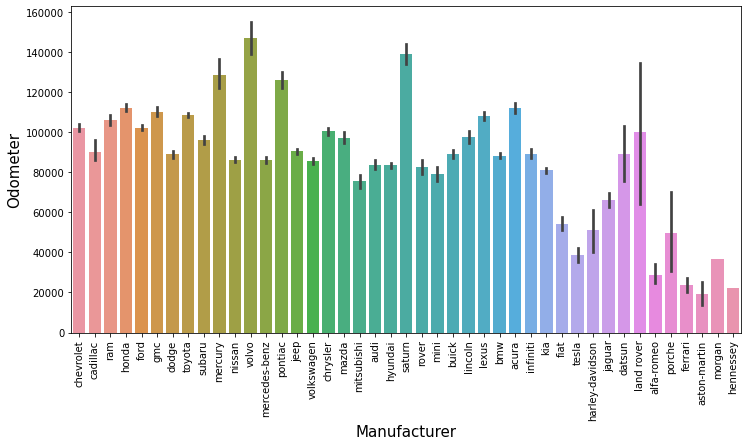

In [7]:
# odometer by manufacturer
dfOdometer=dfVehiclesOriginal.sort_values(by=['odometer'], ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=dfOdometer.manufacturer, y=dfOdometer.odometer)
plt.xticks(rotation= 90)
plt.xlabel('Manufacturer', fontsize=15)
plt.ylabel('Odometer', fontsize=15)
plt.show()

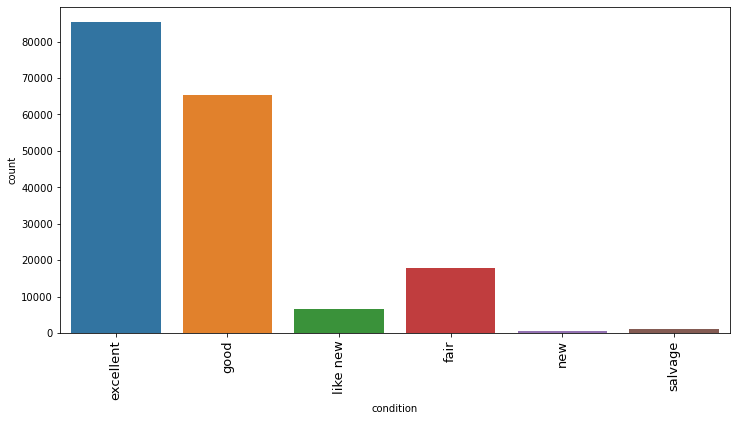

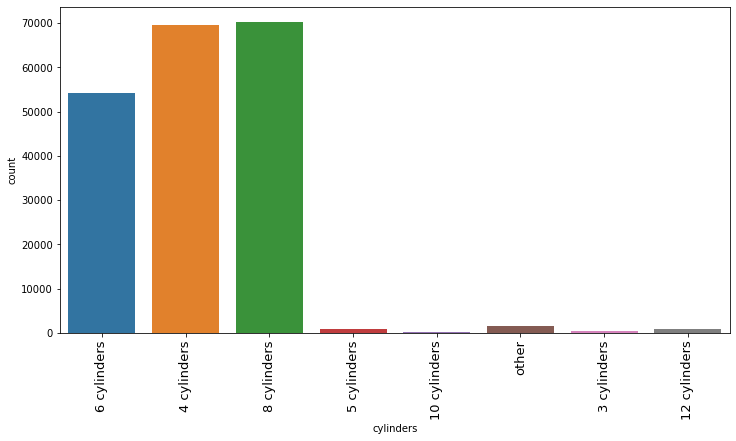

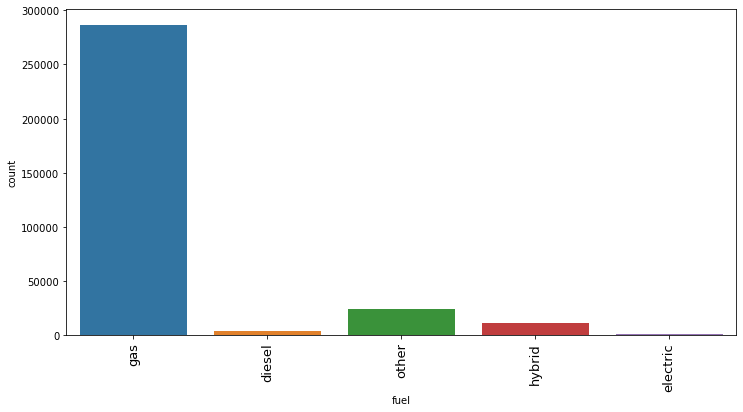

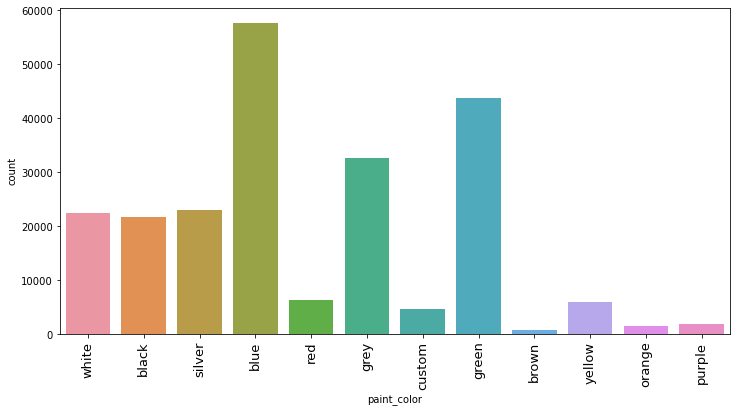

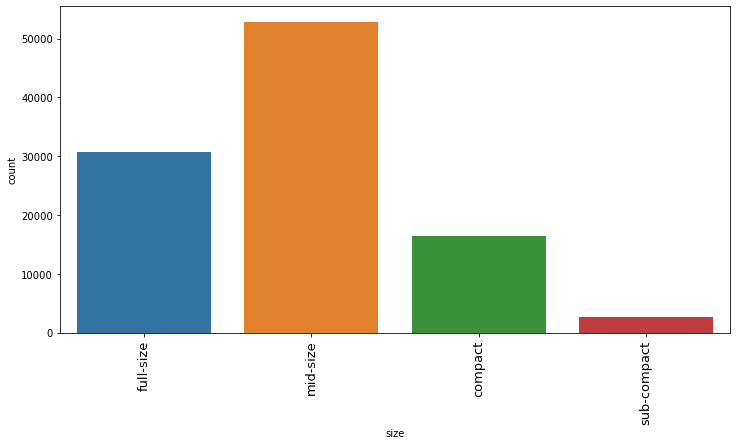

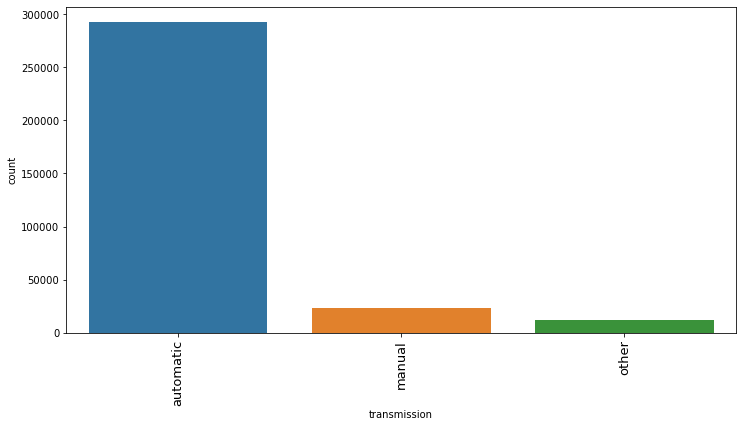

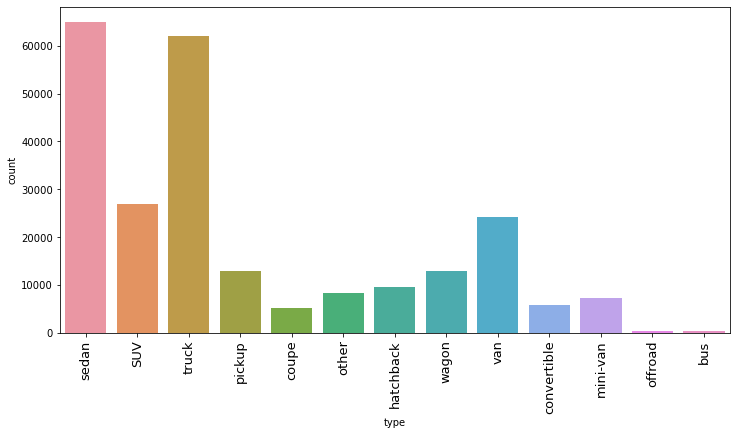

In [8]:
warnings.filterwarnings("ignore")
cols=["condition", "cylinders", "fuel", "paint_color", "size", "transmission", "type"]

for i in cols:
    plt.figure(figsize=(12,6));
    
    g = sns.countplot(dfVehiclesOriginal[i])
    g.set_xticklabels(labels = dfVehiclesOriginal[i].value_counts().index, rotation = 90, fontsize=13)

    plt.show();

## 3. Cleaning the Dataset

### 3.1. Deleting NA values

In [9]:
# Verify number of NA values by column in the data
print("\nNumber of NULL cells - before dropping rows")
print(dfVehiclesOriginal.isnull().sum())

print("\nShape of dataset before NULL cleasing")
print(dfVehiclesOriginal.shape)


Number of NULL cells - before dropping rows
price                0
year             95114
manufacturer    110615
condition       247138
cylinders       226178
fuel             96643
odometer        153272
transmission     95792
size            321230
type            182700
paint_color     201654
dtype: int64

Shape of dataset before NULL cleasing
(423857, 11)


In [10]:
# Delete NA's values
dfVehicles = dfVehiclesOriginal.dropna()

print("\nNumber of NULL cells - after dropping rows")
print(dfVehicles.isnull().sum())

print("\nShape of dataset after NULL cleasing")
print(dfVehicles.shape)


Number of NULL cells - after dropping rows
price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
size            0
type            0
paint_color     0
dtype: int64

Shape of dataset after NULL cleasing
(64452, 11)


### 3.2. Aggregating Columns

Based on the analysis of the frequency distribution of each categorical variable generated after the first cleasing a new round of cleasing process is done.

#### 3.2.1. Deleting rows with variables filled as "other" by the seller (can be hiding right  data not informed by the seller)

In [11]:
dfVehicles['cylinders'] = dfVehicles['cylinders'].apply(lambda x : np.nan if x == "other" else x)
dfVehicles['fuel'] = dfVehicles['fuel'].apply(lambda x : np.nan if x == "other" else x)
dfVehicles['transmission'] = dfVehicles['transmission'].apply(lambda x : np.nan if x == "other" else x)
dfVehicles['type'] = dfVehicles['type'].apply(lambda x : np.nan if x == "other" else x)

dfVehicles.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,size,type,paint_color
id,,,,,,,,,,,
7184712241,16995,2007.0,gmc,good,8 cylinders,diesel,254217.0,automatic,full-size,truck,white
7184711787,13995,2012.0,ford,good,6 cylinders,gas,188406.0,automatic,full-size,truck,grey
7184710887,7995,2010.0,chevrolet,good,4 cylinders,gas,108124.0,automatic,full-size,SUV,grey
7184710023,8995,2011.0,chevrolet,good,6 cylinders,gas,178054.0,automatic,full-size,SUV,white
7184709156,10995,2014.0,ford,good,6 cylinders,gas,170259.0,automatic,full-size,SUV,white


#### 3.2.2. Aggregationg "Car Manufactures" categorial variable with low frequency (they have high standard deviation)

In [12]:
# The model will predict the prices just to a set of manufacturers, those with larger quantity of advertisements

# frequency table of manufacturer
manufecturer_table = pd.crosstab(index = dfVehicles['manufacturer'], columns='count')
manufecturer_table.sort_values(by='count', ascending=False)

col_0,count
manufacturer,
ford,12142
chevrolet,9895
toyota,5262
honda,4138
nissan,3541
gmc,2597
jeep,2574
dodge,2339
ram,2169


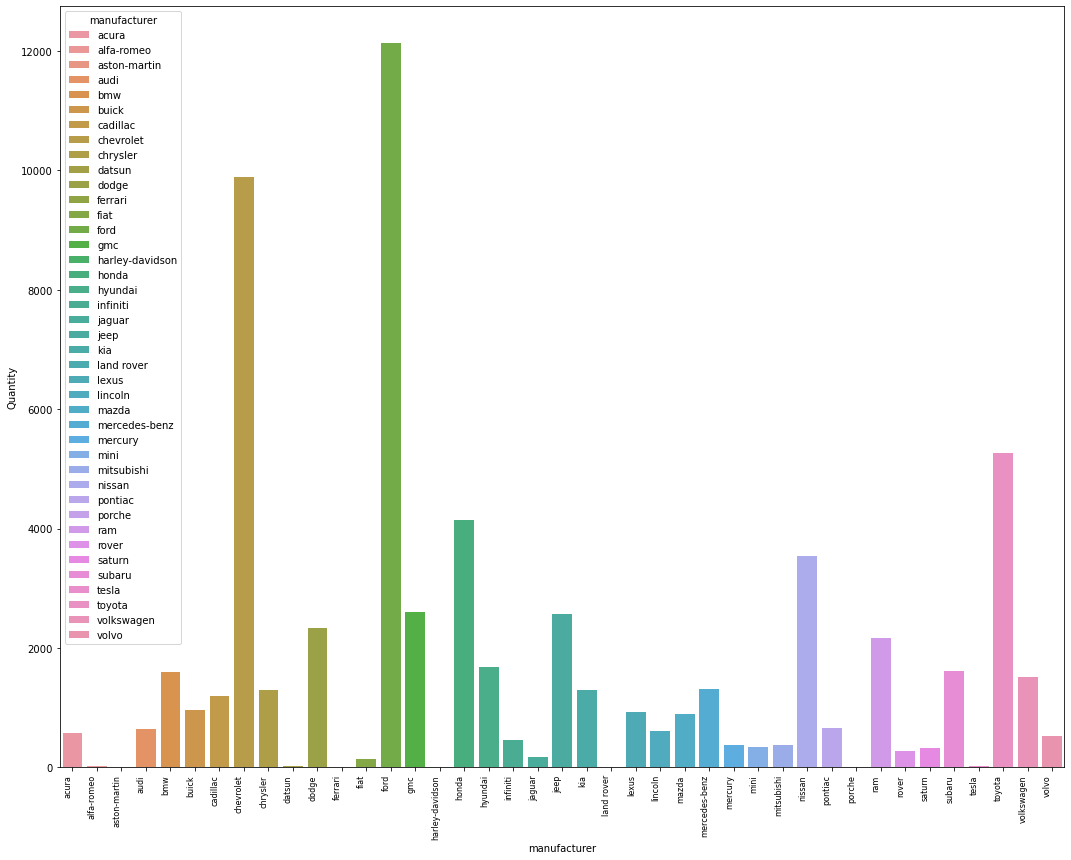

In [13]:
stacked = manufecturer_table.stack().reset_index().rename(columns = {0: 'Quantity'})

fig, ax = plt.subplots(figsize=(18, 14))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=8)
sns.barplot(x=stacked.manufacturer, y=stacked.Quantity, hue=stacked.manufacturer, dodge=False)

In [14]:
# change the actual value to NaN
dfVehicles['manufacturer'] = dfVehicles['manufacturer'].apply(lambda x : np.nan 
    if x in ["tesla", "harley-davidson", "alfa-romeo", "datsun", "ferrari", "land rover", "aston-martin", "porche"]
    else x)

#### 3.2.3. Aggregationg "Condition" categorial variable since it depends on the interpretation

In [15]:
# "fair" and "good" conditions grouped in one category
# "new" and "like new" conditions grouped in one category

condition_table = pd.crosstab(index=dfVehicles['condition'], columns='count')
condition_table

col_0,count
condition,
excellent,31733
fair,2601
good,21656
like new,7926
new,347
salvage,189


In [16]:
dfVehicles['condition'] = dfVehicles['condition'].apply(lambda x : "good" if x in [ "fair", "good" ] else x)
dfVehicles['condition'] = dfVehicles['condition'].apply(lambda x : "new" if x in [ "new", "like new" ] else x)

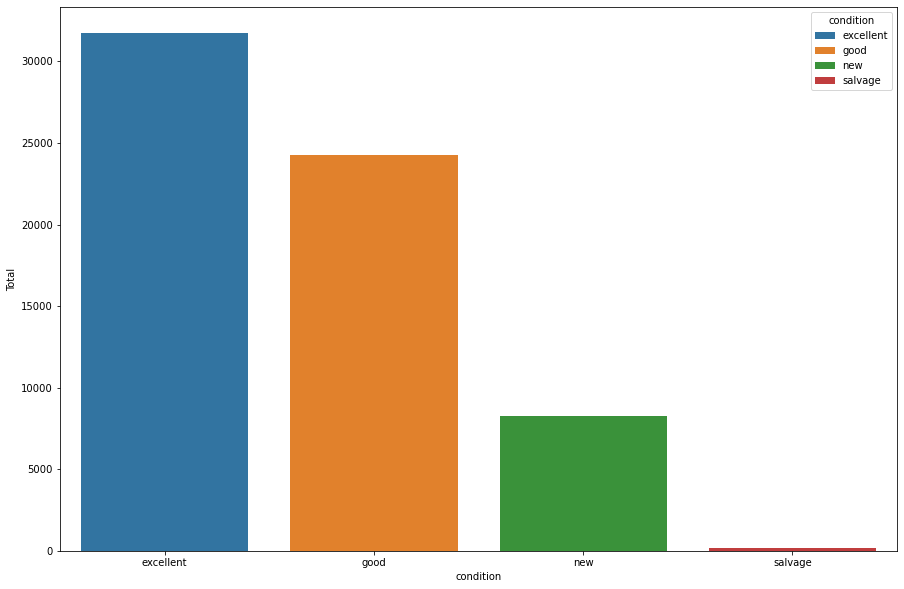

In [17]:
# "fair" and "good" conditions grouped in one category
# "new" and "like new" conditions grouped in one category

condition_table = pd.crosstab(index=dfVehicles['condition'], columns='count')
stacked = condition_table.stack().reset_index().rename(columns = {0: 'Total'})

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=stacked.condition, y=stacked.Total, hue=stacked.condition, dodge=False)

### 3.3. Deleting "utility" type vehicles

In [18]:
# all rows of utility vehicles (except pickups) will be eliminated like 'truck' and 'bus'

type_table = pd.crosstab(index=dfVehicles['type'], columns='count')
type_table.sort_values(by='count', ascending=False)

col_0,count
type,
sedan,18281
SUV,17376
truck,9481
pickup,4706
coupe,3739
hatchback,2657
van,2596
mini-van,1815
convertible,1715


In [19]:
# eliminating 'truck' and 'bus'
dfVehicles['type'] = dfVehicles['type'].apply(lambda x : np.nan if x in [ "truck", "bus" ] else x)

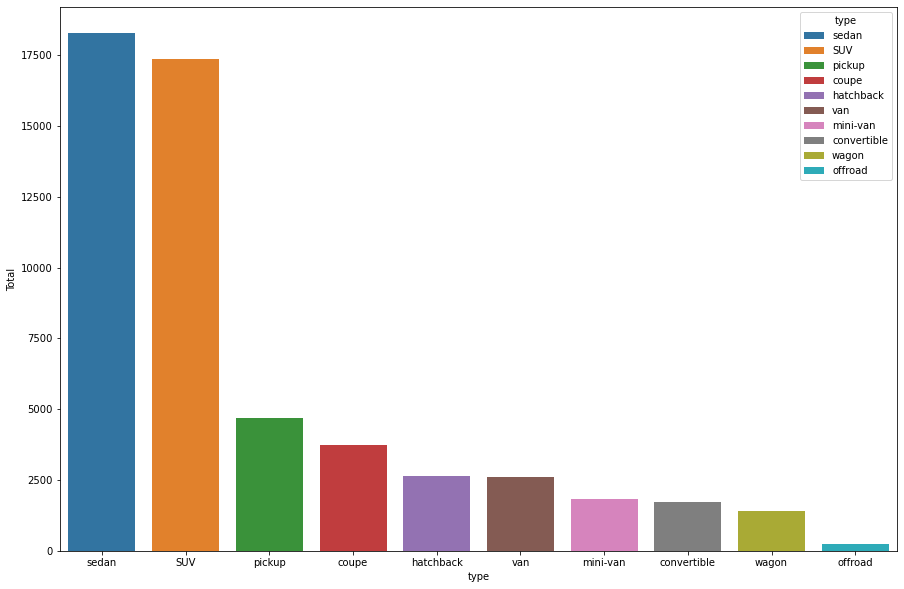

In [20]:
type_table = pd.crosstab(index=dfVehicles['type'], columns='count')
type_table.sort_values(by='count', ascending=False)
stacked = type_table.sort_values(by='count', ascending=False).stack().reset_index().rename(columns = {0: 'Total'})

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=stacked.type, y=stacked.Total, hue=stacked.type, dodge=False)

### 3.4. Deleting "exotic" colors

In [21]:
# all colors with low frequency in the distribution will be grouped together as "exotic" colors

color_table = pd.crosstab(index=dfVehicles['paint_color'], columns='count')
color_table.sort_values(by='count', ascending=False)

col_0,count
paint_color,
white,15578
black,11468
silver,9588
grey,7528
blue,6879
red,6637
green,2065
brown,1947
custom,1692


In [22]:
dfVehicles['paint_color'] = dfVehicles['paint_color'].apply(lambda x : "exotic" 
    if x in ["orange", "yellow", "purple", "custom"] 
    else x)

### 3.5. Deleting "unreal" car prices

In [23]:
# all prices informed as below US$ 1000 will be deleted 
#     sometimes sellers put any low amount on the advertisement such as 0, 10, etc, just to catch the attention 
#     of potential buyers to get a open offer for the vehicle

dfVehicles['price'] = dfVehicles['price'].apply(lambda x : np.nan if x < 1000 else x)

### 3.6. Deleting rows with no odometer information

In [24]:
dfVehicles['odometer'] = dfVehicles['odometer'].apply(lambda x : np.nan if x <= 0 else x)

### 3.7. Deleting all NA values created

In [25]:
# Verify number of NA values by column in the data
print("\nNumber of NULL cells - before dropping rows")
print(dfVehicles.isnull().sum())

print("\nShape of dataset before NULL cleasing")
print(dfVehicles.shape)


Number of NULL cells - before dropping rows
price           3937
year               0
manufacturer      83
condition          0
cylinders        210
fuel              86
odometer         204
transmission     390
size               0
type            9943
paint_color        0
dtype: int64

Shape of dataset before NULL cleasing
(64452, 11)


In [26]:
# Delete NA's values
dfVehicles.dropna(inplace=True)

print("\nNumber of NULL cells - after dropping rows")
print(dfVehicles.isnull().sum())

print("\nShape of dataset after NULL cleasing")
print(dfVehicles.shape)


Number of NULL cells - after dropping rows
price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
size            0
type            0
paint_color     0
dtype: int64

Shape of dataset after NULL cleasing
(50615, 11)


## 4. Data Processing

### 4.1. Correlation and Association Analysis

In [27]:
# Examining the correlation matrix in order to eliminate redundant variables highly correlated and to simplify the model
corr = dfVehicles.corr()
corr.to_csv("correlation.csv")

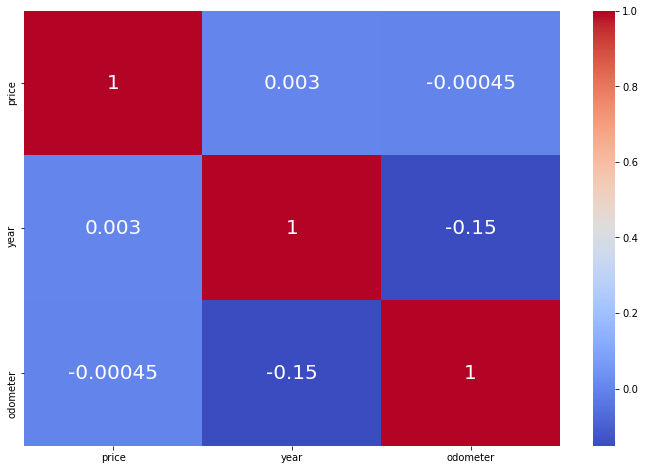

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2g', annot_kws={"size": 20})
plt.savefig('Correlation')
plt.show()

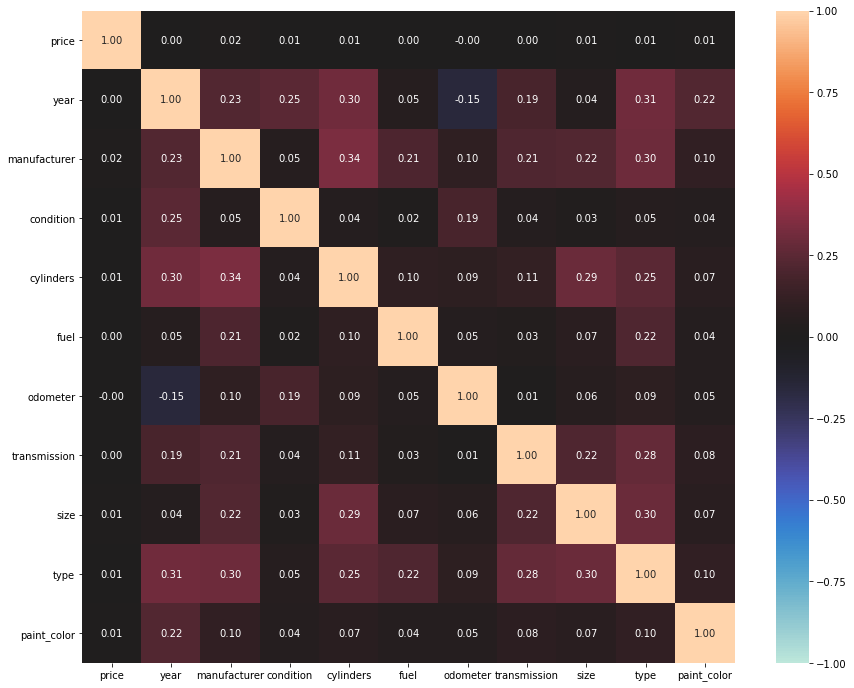

In [29]:
# for categorical and nominal variables it is used Cramer's V algorithm
corr, ax = nominal.associations(dfVehicles, figsize=(15,12), mark_columns=False)

### 4.2. Dummy Variables

In [30]:
# transform categorical variables into dummy variables
categorical = ['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission', 'size', 'type', 'paint_color']
dfVehiclesCat = pd.get_dummies(dfVehicles, columns=categorical, drop_first=False)

In [31]:
# delete the reference variables
referenceVars = ['manufacturer_ford', 'condition_good', 'cylinders_6 cylinders', 'fuel_gas', 'transmission_automatic', 
                 'size_mid-size', 'type_sedan', 'paint_color_black']
dfVehiclesCat = dfVehiclesCat.drop(columns = referenceVars, axis = 1)

In [32]:
print("Columns after categorical columns are converted to dummy\n")
print(dfVehiclesCat.columns)

Columns after categorical columns are converted to dummy

Index(['price', 'year', 'odometer', 'manufacturer_acura', 'manufacturer_audi',
       'manufacturer_bmw', 'manufacturer_buick', 'manufacturer_cadillac',
       'manufacturer_chevrolet', 'manufacturer_chrysler', 'manufacturer_dodge',
       'manufacturer_fiat', 'manufacturer_gmc', 'manufacturer_honda',
       'manufacturer_hyundai', 'manufacturer_infiniti', 'manufacturer_jaguar',
       'manufacturer_jeep', 'manufacturer_kia', 'manufacturer_lexus',
       'manufacturer_lincoln', 'manufacturer_mazda',
       'manufacturer_mercedes-benz', 'manufacturer_mercury',
       'manufacturer_mini', 'manufacturer_mitsubishi', 'manufacturer_nissan',
       'manufacturer_pontiac', 'manufacturer_ram', 'manufacturer_rover',
       'manufacturer_saturn', 'manufacturer_subaru', 'manufacturer_toyota',
       'manufacturer_volkswagen', 'manufacturer_volvo', 'condition_excellent',
       'condition_new', 'condition_salvage', 'cylinders_10 cylinders',

In [33]:
dfVehiclesCat.shape

(50615, 68)

### 4.3. Data Normalization

#### 4.3.1. Rescaling large numerical values to logaritmic base

In [34]:
# columns: "Price" and "Odometer"
dfVehiclesCat['price_log'] = dfVehiclesCat['price'].apply(lambda x : np.log(x))
dfVehiclesCat['odometer_log'] = dfVehiclesCat['odometer'].apply(lambda x : np.log(x))

# delete the original columns
dfVehiclesCat.drop(columns = ['price','odometer'], axis = 1, inplace=True)

#### 4.3.2. Deleting vehicles older than 20 years

In [35]:
# car year model 2021 as 0 year old
# older cars in such situation must be considered as rare and collectable

# define the variable 'age'
dfVehiclesCat['age'] = dfVehiclesCat['year'].apply(lambda x : 2021 - x)
dfVehiclesCat = dfVehiclesCat.drop(columns = ['year'], axis = 1)

# setting to NaN where cars are greater than 20
dfVehiclesCat['age'] = dfVehiclesCat['age'].apply(lambda x : np.nan if x > 20 else x)

In [36]:
dfVehiclesCat.dropna(inplace=True)

print("\nNumber of NULL cells - after dropping rows - last cleasing")
print(dfVehiclesCat.isnull().sum())

print("\nShape of dataset after NULL cleasing")
print(dfVehiclesCat.shape)

dfVehiclesCat.to_csv("cleaned.csv")


Number of NULL cells - after dropping rows - last cleasing
manufacturer_acura       0
manufacturer_audi        0
manufacturer_bmw         0
manufacturer_buick       0
manufacturer_cadillac    0
                        ..
paint_color_silver       0
paint_color_white        0
price_log                0
odometer_log             0
age                      0
Length: 68, dtype: int64

Shape of dataset after NULL cleasing
(45789, 68)


In [37]:
dfVehiclesCat.to_csv("DatasetProcessed_CleanedDummies.csv", index=False)

## 5. Data Modeling

### 5.1. Ordinary Least Squares (OLS) Applied to All Dataset

In [38]:
import statsmodels.api as sm

# define 'x' and 'y'
outcomeVar = ['price_log']

explanVars = dfVehiclesCat.columns.values.tolist()
explanVars.remove('price_log')

print(dfVehiclesCat[outcomeVar].shape)
print(dfVehiclesCat[explanVars].shape)

(45789, 1)
(45789, 67)


#### 5.1.1. Adjusting the model

In [39]:
# Model summary Analysis
model_name = "OLS - Ordinary Least Squares"

y = dfVehiclesCat[outcomeVar]
X = sm.add_constant(dfVehiclesCat[explanVars])

model = sm.OLS(y, X)
results = model.fit()

In [40]:
print("Model {} Summary \n".format(model_name))
print(results.summary2())

print('\nPredicted values: \n',results.predict())

Model OLS - Ordinary Least Squares Summary 

                      Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.689     
Dependent Variable:    price_log           AIC:                   50624.7161
Date:                  2020-11-25 17:31    BIC:                   51218.4784
No. Observations:      45789               Log-Likelihood:        -25244.   
Df Model:              67                  F-statistic:           1515.     
Df Residuals:          45721               Prob (F-statistic):    0.00      
R-squared:             0.689               Scale:                 0.17662   
----------------------------------------------------------------------------
                            Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------------
const                      10.4813   0.0224  468.5617 0.0000 10.4375 10.5252
manufacturer_acura          0.3470   0.0197   17.6040 

#### 5.1.2. Computting the Exponential Coefficients

In [41]:
params = results.params
conf = results.conf_int()

conf['Exp'] = params
conf.columns = ['2.5%', '97.5%', 'Exp']

print("\nExponential Coefficients")
print("-----------------------------------------------------------------")
print(np.exp(conf).round(5).to_string())


Exponential Coefficients
-----------------------------------------------------------------
                                   2.5%        97.5%          Exp
const                       34115.08354  37241.64018  35644.09721
manufacturer_acura              1.36121      1.47056      1.41483
manufacturer_audi               1.46757      1.57674      1.52118
manufacturer_bmw                1.34526      1.41513      1.37975
manufacturer_buick              1.06619      1.13831      1.10166
manufacturer_cadillac           1.24166      1.31943      1.27995
manufacturer_chevrolet          0.98317      1.01288      0.99791
manufacturer_chrysler           0.90287      0.95454      0.92835
manufacturer_dodge              0.93632      0.97933      0.95758
manufacturer_fiat               0.69852      0.82260      0.75802
manufacturer_gmc                1.06875      1.12223      1.09516
manufacturer_honda              1.22249      1.26719      1.24464
manufacturer_hyundai            0.95255      0.999

#### 5.1.3. Features Reduction

In [42]:
# create two list of variables - statistically significant and not
columns_significance = results.summary2().tables[1]['P>|t|']
print(columns_significance)

data_columns = X.columns
features_table = pd.DataFrame(data=zip(data_columns, columns_significance), 
                              columns=['Feature', 'Statistically Significant'])

const                  0.000000e+00
manufacturer_acura     3.884318e-69
manufacturer_audi     1.395289e-115
manufacturer_bmw      3.752112e-136
manufacturer_buick     6.724210e-09
                          ...      
paint_color_red        7.684844e-02
paint_color_silver     1.241055e-05
paint_color_white      8.918860e-02
odometer_log          8.139035e-207
age                    0.000000e+00
Name: P>|t|, Length: 68, dtype: float64


In [43]:
non_significant_columns = []
significant_columns = []

for i in range(len(columns_significance)):
    if columns_significance[i] > 0.05:
        non_significant_columns.append(data_columns[i])
    else:
        significant_columns.append(data_columns[i])

num_columns_kept = len(columns_significance) - len(non_significant_columns)

print("\nNumber of Columnns to be KEPT after features reduction using {}    : {}".format(model_name, 
                                                                                      num_columns_kept))
print("Number of Columnns to be REMOVED after features reduction using {} : {}".format(model_name,
                                                                                       len(non_significant_columns)))
print("\nColumns to be KEPT")
print(significant_columns)

print("\nColumns to be REMOVED")
print(non_significant_columns)

X = X.loc[:,significant_columns]



Number of Columnns to be KEPT after features reduction using OLS - Ordinary Least Squares    : 57
Number of Columnns to be REMOVED after features reduction using OLS - Ordinary Least Squares : 11

Columns to be KEPT
['const', 'manufacturer_acura', 'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_buick', 'manufacturer_cadillac', 'manufacturer_chrysler', 'manufacturer_dodge', 'manufacturer_fiat', 'manufacturer_gmc', 'manufacturer_honda', 'manufacturer_hyundai', 'manufacturer_infiniti', 'manufacturer_jaguar', 'manufacturer_jeep', 'manufacturer_kia', 'manufacturer_lexus', 'manufacturer_lincoln', 'manufacturer_mazda', 'manufacturer_mercedes-benz', 'manufacturer_mercury', 'manufacturer_mini', 'manufacturer_mitsubishi', 'manufacturer_nissan', 'manufacturer_ram', 'manufacturer_rover', 'manufacturer_saturn', 'manufacturer_subaru', 'manufacturer_toyota', 'manufacturer_volvo', 'condition_excellent', 'condition_new', 'condition_salvage', 'cylinders_10 cylinders', 'cylinders_12 cylinders', '

#### 5.1.4. Removing outliers using Cooks Distance Model

In [44]:
print("starting influencials... \n")

infl = results.get_influence()

percentage_outliers = 15
threshold = np.nanpercentile(infl.cooks_distance[0], 100 - percentage_outliers, interpolation='midpoint')

print("Threshold                             : {0:.4g}". format(threshold))

dfInfluencials = pd.DataFrame(zip(X.index.values.tolist(), infl.cooks_distance[0]), columns = ["index","cooks_d"])
dfInfluencials = dfInfluencials.set_index('index')

# identify the outliers
outliers = dfInfluencials.loc[dfInfluencials["cooks_d"] > threshold].index

print("# of rows BEFORE outliers elimination : {}". format(X.shape[0]))
print("# of outliers identified              : {}". format(len(outliers)))

X = X[~ X.index.isin(outliers)]
y = y[~ y.index.isin(outliers)]

print("# of rows AFTER outliers elimination  : {}". format(X.shape[0]))

print("\nfinishig influencials...")

starting influencials... 

Threshold                             : 2.816e-05
# of rows BEFORE outliers elimination : 45789
# of outliers identified              : 6869
# of rows AFTER outliers elimination  : 38920

finishig influencials...


#### 5.1.5. Adjusting the model after Features Reduction and Outliers Elimination

In [45]:
model = sm.OLS(y, X)
results = model.fit()

print("\nModel {} - Summary AFTER Features Reduction and Outliers Elimination\n".format(model_name))
print(results.summary())


Model OLS - Ordinary Least Squares - Summary AFTER Features Reduction and Outliers Elimination

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     4427.
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:31:21   Log-Likelihood:                -658.41
No. Observations:               38920   AIC:                             1431.
Df Residuals:                   38863   BIC:                             1919.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

### 5.2. OLS, Ridge, and Lasso Models Applied with Training and Testing Datasets

The goal is to estimate OLS, Ridge, and Lasso models using the training dataset and assess their predictive performance using the testing dataset by RMSE statistic. 

Note: for Ridge and Lasso regressions, firsly we will determine the optimal regularization parameter. To perform this step we will use the cross-validation technique for a specific set of values (1e-8, 1e-4, 1e-3, 1e-2, 0.1, 1, 2, 5, 10).

#### 5.2.1. Loading libraries

In [46]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# library for OLS - Ordinary Least Squares model
from sklearn.linear_model import LinearRegression

# library for RIDGE model
from sklearn import linear_model

# library for LASSO model
from sklearn.linear_model import Lasso

#### 5.2.2. Spliting the dataset

In [47]:
# The dataset is split into 70% for training and 30% for testing
dfTrain,dfTest = train_test_split(dfVehiclesCat, test_size=0.4, random_state=123)

# Create a dataframe to store the results
dfRevModelResults = pd.DataFrame( { 'Model' : [], 'RMSE' : [] } )

X_train = dfTrain[explanVars]
y_train = dfTrain[outcomeVar]

X_test = dfTest[explanVars]
y_test = dfTest[outcomeVar]

print("X train : {}" . format(X_train.shape))
print("y train : {}" . format(y_train.shape))
print("X test  : {}" . format(X_test.shape))
print("y test  : {}" . format(y_test.shape))

X train : (27473, 67)
y train : (27473, 1)
X test  : (18316, 67)
y test  : (18316, 1)


In [48]:
print(X_train.head())

            manufacturer_acura  manufacturer_audi  manufacturer_bmw  \
id                                                                    
7187779742                   0                  0                 1   
7182872906                   0                  0                 0   
7193118382                   0                  0                 0   
7180446503                   0                  0                 0   
7193354486                   0                  0                 0   

            manufacturer_buick  manufacturer_cadillac  manufacturer_chevrolet  \
id                                                                              
7187779742                   0                      0                       0   
7182872906                   0                      0                       0   
7193118382                   0                      0                       0   
7180446503                   0                      0                       1   
7193354486      

In [49]:
print(y_train.head())

            price_log
id                   
7187779742   9.615472
7182872906   9.792556
7193118382   7.783224
7180446503   8.630522
7193354486   8.892886


In [50]:
print(X_test.head())

            manufacturer_acura  manufacturer_audi  manufacturer_bmw  \
id                                                                    
7178768924                   0                  0                 0   
7189924490                   0                  0                 0   
7187793232                   0                  0                 0   
7188076043                   0                  0                 0   
7186601263                   0                  0                 0   

            manufacturer_buick  manufacturer_cadillac  manufacturer_chevrolet  \
id                                                                              
7178768924                   0                      0                       1   
7189924490                   0                      0                       0   
7187793232                   0                      0                       0   
7188076043                   0                      0                       0   
7186601263      

In [51]:
print(y_test.head())

            price_log
id                   
7178768924   9.238928
7189924490   7.699389
7187793232   9.047821
7188076043   9.729134
7186601263   9.851931


#### 5.2.3. Linear Regression

In [52]:
lr = LinearRegression()

results_lr = lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

lr_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr))

dfRevModelResults = dfRevModelResults.append( { 'Model' : "LinearRegression" , 'RMSE' : lr_RMSE }, ignore_index=True )

#### 5.2.4. Ridge Regression

In [53]:
alphas = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 1, 2, 5, 10]

ridge_reg = linear_model.RidgeCV(alphas=alphas, store_cv_values=True)
ridge_reg.fit(X_train, y_train)

alpha = ridge_reg.alpha_
ridge_reg = linear_model.Ridge(alpha = ridge_reg.alpha_)
results_ridge = ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)
ridge_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge))

print("Best 'alpha' for Ridge = {}" . format(alpha))

dfRevModelResults = dfRevModelResults.append( { 'Model' : "Ridge" , 'RMSE' : ridge_RMSE }, ignore_index=True )

Best 'alpha' for Ridge = 1.0


#### 5.2.5. Lasso Regression

In [54]:
lasso = Lasso()

alphas = {'alpha':[1e-8, 1e-4, 1e-3, 1e-2, 0.1, 1, 2, 5, 10]}

lasso_regressor = GridSearchCV(lasso,alphas,scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train,y_train)

alpha = lasso_regressor.best_params_['alpha']
print("Best 'alpha' for Lasso = {}" . format(alpha))

lasso = Lasso(alpha=alpha)

results_lasso = lasso.fit(X_train,y_train)

y_pred_lasso = lasso.predict(X_test)

lasso_RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_pred_lasso))

dfRevModelResults = dfRevModelResults.append( { 'Model' : "Lasso" , 'RMSE' : lasso_RMSE }, ignore_index=True )

Best 'alpha' for Lasso = 1e-08


#### 5.2.6. Determining the best model

In [55]:
print("\nRMSE Comparison among the 3 methods\n")
print(dfRevModelResults)

bestModel =  dfRevModelResults.loc[ (dfRevModelResults['RMSE'] == dfRevModelResults['RMSE'].min()) ]

print("\nThe BEST model is :")
print(bestModel)

bestModelName = bestModel.iloc[0,0]

if (bestModelName == "LinearRegression"):
    predictor = lr
elif (bestModelName == "Ridge"):
    predictor = ridge_reg
else:
    predictor = lasso

if predictor == lasso:
    y_pred = y_pred_lasso
    results = results_lasso
else:
    y_pred = y_pred_lr[:,0]
    if predictor == lr:
        results = results_lr
    else:
        results = results_ridge


RMSE Comparison among the 3 methods

              Model      RMSE
0  LinearRegression  0.412698
1             Ridge  0.412723
2             Lasso  0.412698

The BEST model is :
              Model      RMSE
0  LinearRegression  0.412698


## 6. Residuals Analysis

In [56]:
# determining the residuals
residuals = np.subtract(np.exp(y_test[outcomeVar[0]].to_list()), np.exp(y_pred))

dfResiduals =  pd.DataFrame(zip(y_test.index.values.tolist() , 
                                np.exp(y_test[outcomeVar[0]].to_list()),
                                np.exp(y_pred), residuals), 
                            columns = ["index", "actual_price", "predicted_price", "residual"])

dfResiduals = dfResiduals.set_index('index')
dfResiduals = pd.merge(dfResiduals, dfVehicles, left_index=True, right_index=True, how="left")

dfResiduals.to_csv("residuals.csv")

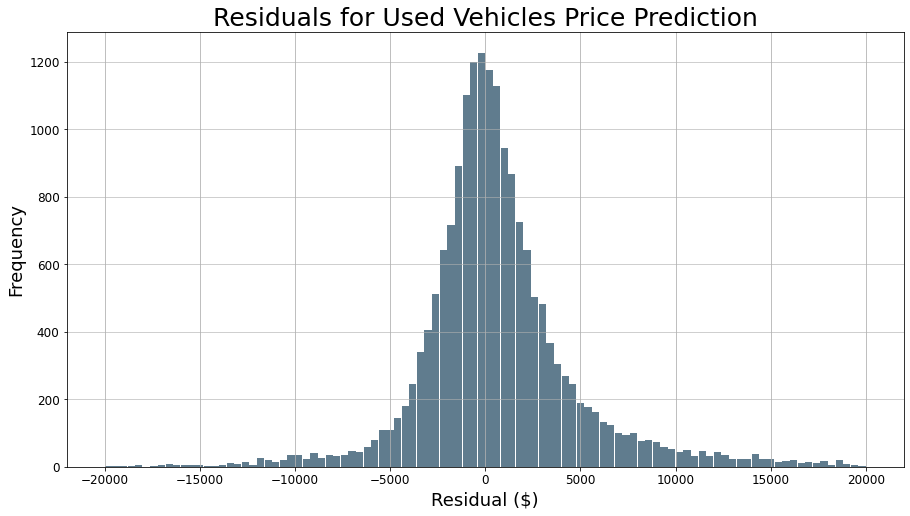

In [57]:
# plotting the histogram
srResiduals = pd.Series(residuals)

plt.subplots(figsize=(15,8))
srResiduals.plot.hist(grid=True, bins=100, rwidth=0.95, range = [-20000, 20000], color='#607c8e', fontsize=12)

plt.title('Residuals for Used Vehicles Price Prediction', fontsize=25)
plt.xlabel('Residual ($)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.grid(axis='y', alpha=0.75)

plt.savefig('Residual')

## 7. Predictions

Using the best model, let's predict the price of the following cars:

**Car #1**

* Manufacturer = Honda
* Condition = Good
* Cylinders = 6 cylinders
* Fuel = Gas
* Transmission = Automatic
* Size = mid-size
* Type = Sedan
* Paint color = Black
* Odometer = 22,000 miles (Odometer_log = 10)
* Age = 5 years old

In [58]:
new_car1 = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 5]]

In [59]:
print('-----------------------------------------------')
print('The predicted price of this car is: $ {:0,.2f}'.format(np.exp(lr.predict(new_car1))[0][0]))
print('-----------------------------------------------')

-----------------------------------------------
The predicted price of this car is: $ 14,222.30
-----------------------------------------------


**Car #2**

* Manufacturer = Hyundai
* Condition = New
* Cylinders = 10 cylinders
* Fuel = Diesel
* Transmission = Automatic
* Size = mid-size
* Type = SUV
* Paint color = Silver
* Odometer = 10,000 miles (Odometer_log = 9.2)
* Age = 2 years old

In [60]:
new_car2 = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 
             0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 9.2, 2]]

In [61]:
print('-----------------------------------------------')
print('The predicted price of this car is: $ {:0,.2f}'.format(np.exp(lr.predict(new_car2))[0][0]))
print('-----------------------------------------------')

-----------------------------------------------
The predicted price of this car is: $ 77,876.45
-----------------------------------------------


**Car #3**

* Manufacturer = Jaguar
* Condition = Excellent
* Cylinders = 12 cylinders
* Fuel = Hybrid
* Transmission = Automatic
* Size = mid-size
* Type = convertible
* Paint color = White
* Odometer = 30,000 miles (Odometer_log = 9.3)
* Age = 3 years old

In [62]:
new_car3 = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 
             0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9.3, 3]]

In [63]:
print('------------------------------------------------')
print('The predicted price of this car is: $ {:0,.2f}'.format(np.exp(lr.predict(new_car3))[0][0]))
print('------------------------------------------------')

------------------------------------------------
The predicted price of this car is: $ 110,947.61
------------------------------------------------
